DiffEdit Implementation

This is a basic implementation of the [DiffEdit](https://arxiv.org/pdf/2210.11427) paper using stable diffusion and text prompts to change certain aspects of a certain input image without having to manually create masks such as in other techniques.

In [126]:
import logging
from pathlib import Path
import io
import cv2
import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import display
import torchvision.transforms as transforms
import numpy as np
from torchvision import transforms as tfms
from tqdm.auto import tqdm

beta_start,beta_end = 0.00085,0.012

logging.disable(logging.WARNING)

torch.manual_seed(100)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

The main pipeline is going to take the shape of a autoencoder, used to transform the image and text embeddings into the latent space and similarly decode them back into the image space, we obviously use a basic unet to denoise the noisey latents and also the Clip encoder to transform our prompt into embeddings and the clip tokenizer to transform our text into encodable tokens. Alongside this we will also use a scheduler which will serve to add noise to our inputs.

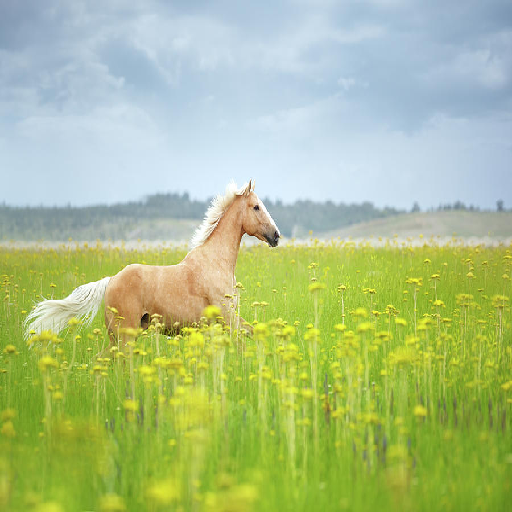

In [304]:
from diffusers import AutoencoderKL,UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import LMSDiscreteScheduler
horse_img = Image.open('horseinfield.jpg')
horse_img=horse_img.resize((512,512),0)
# Define a transform to convert the image to tensor
display(horse_img)

In [263]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

Using a vae both to encode and decode the images/latents

In [318]:

def encode_img(input_img):
    # Single image -> single latent in~ a batch (so size 1, 4, 64, 64)
    input_img=input_img.resize((512,512),0)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_img).unsqueeze(0).half().to("cuda")*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()
    
def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    return images

Getting embeddings for a given prompt

In [319]:
def get_text_embeddings(prompt,tokenizer, text_encoder, device):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""], padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    return text_embeddings

Creating Noisey Latents

In [320]:
def get_noise(prompt,input_img,num_steps,guidance,generator,batch_size,mask=None):
    noisey_latents = torch.tensor([], device='cuda')
    encoded_img = encode_img(input_img)
    text_embeddings = get_text_embeddings(prompt,tokenizer,text_encoder,"cuda")
    scheduler.set_timesteps(num_inference_steps)
    start_step = num_steps//2
    start_sigma = scheduler.sigmas[start_step]
    noise = torch.randn(encoded_img.shape).to("cuda").half()
    latents = scheduler.add_noise(encoded_img,noise,timesteps=torch.tensor([scheduler.timesteps[start_step]]))
    latents = latents.to("cuda").half()
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        if i >= start_step: # << This is the only modification to the loop we do
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            if mask is not None: 
                latents = mask*latents+(1-mask)*encoded_img
                #latents=latents.to("cuda").half()
            noisey_latents = torch.concat((noisey_latents, noise_pred))
            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents).prev_sample
    return latents,noisey_latents


Mask used to deciding which pixels to alter and which that cannot be altered when doing the final diffusion run.

In [321]:
def extract_channel_mask(img, do_inverse=False):
    kernel = np.ones((3,3),np.uint8)
    img = (img*255).squeeze().cpu().to(torch.uint8).numpy()
    if do_inverse:
        ret2,img2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        ret2,img2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    opening = cv2.dilate(img2, kernel)
    return opening

In [322]:
def mask_creation(uncon_latents,prompt_latents):
    #finding the difference between latents
    diff_latents = (uncon_latents-prompt_latents).mean()(0,keepdim=True)
    #taking the absolute value for each value
    diff_latents = diff_latents.abs()
    #Normalization
    diff_latents = (diff_latents-diff_latents.min()/(diff_latents - diff_latents.min()).max())
    mask = diff_latents.mean(dim=1).squeeze()
    final_mask = extract_channel_mask(mask)
    final_mask = torch.from_numpy((final_mask/255)).half().cuda()
    return final_mask
    

Main function which takes the input image, and inital prompt about the image and a final prompt and what to
transform the image into.

In [323]:
def image_changer(image,cond_prompt,prompt):
    image=image.resize((512,512),0)
    prompt_latents = torch.tensor([], device='cuda')
    nonprompt_latents = torch.tensor([], device='cuda')
    for i in range(0,10):
        dummy_img,prompt_latent_noise = get_noise(prompt,image,70,7.5,1000,1)
        dummy_img2,nonprompt_latent_noise = get_noise(cond_prompt,image,70,7.5,1000,1)
        prompt_latents=torch.cat((prompt_latents,prompt_latent_noise))
        nonprompt_latents=torch.cat((nonprompt_latents,nonprompt_latent_noise))
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    diff_noises = (prompt_latent_noise-nonprompt_latent_noise).mean(0,keepdim=True)
    for c in range(4):
        axs[c].imshow(diff_noises[0][c].cpu())#, cmap='Greys')
    mask = mask_generation(prompt_latent_noise,nonprompt_latent_noise)
    image_latent,dummy_noise_latent = get_noise(prompt,image,70,7.5,1000,1)
    final_image = decode_img(image_latent)[0]
    return final_image
    

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

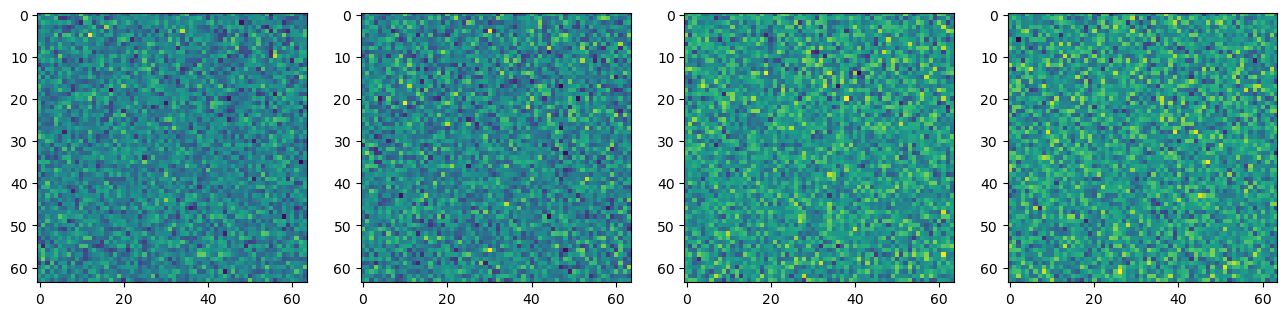

In [324]:
image = image_changer(horse_img,"A horse in a field.","A seagull in a field.")

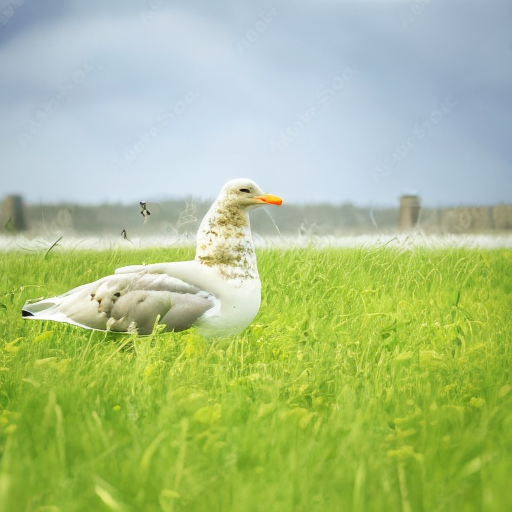

In [325]:
Image.fromarray(image)

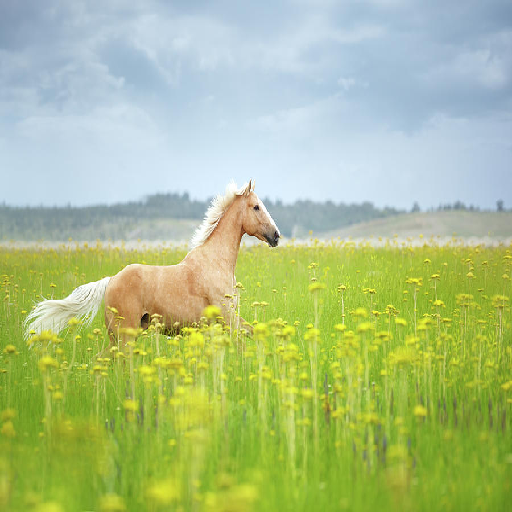

In [310]:
horse_img = Image.open('horseinfield.jpg')
horse_img=horse_img.resize((512,512),0)
# Define a transform to convert the image to tensor
display(horse_img)